In [1]:
import os
GPU_id = 6
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import cudf as gd
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import time
import nvstrings
from librmm_cffi import librmm
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

In [3]:
def on_gpu(words,func,arg=None,dtype=np.int32):
    res = librmm.device_array(words.size(), dtype=dtype)
    if arg is None:
        cmd = 'words.%s(res.device_ctypes_pointer.value)'%(func)
    else:
        cmd = 'words.%s(arg,res.device_ctypes_pointer.value)'%(func)
    eval(cmd)
    return res

### Read data

In [4]:
path = '/datasets/trivago/data/'
os.listdir(path)

['item_metadata.csv',
 'submission_popular.csv',
 'test.csv',
 'train.csv',
 'text_classification_full.pkl',
 'bin_itemmeta.csv',
 'distribution_compliance_per_filter_per_search.csv',
 'positive_compliance_vs_negative_compliance.csv',
 'data_link_current_filters_metadata.csv',
 'poi_per_user_per_session.csv',
 'destinations_per_user_per_session.csv']

In [5]:
%%time
train = gd.read_csv('%s/train.csv'%path)
test = gd.read_csv('%s/test.csv'%path)
submission = pd.read_csv('%s/submission_popular.csv'%path)
train['is_test'] = 0
test['is_test'] = 1
print("train & test",train.shape,test.shape)
data = gd.concat([train,test])
print('combined',data.shape)

train & test (15932992, 13) (3782335, 13)
combined (19715327, 13)
CPU times: user 3.6 s, sys: 2.11 s, total: 5.72 s
Wall time: 8.85 s


In [6]:
del train
del test

### only keep click out rows for this version

In [7]:
%%time
data['is_click_out'] = on_gpu(data['action_type'].data,'compare',arg='clickout item')
data['is_click_out'] = data['is_click_out']==0 # 0 means string match
data['is_click_out'] = data['is_click_out'].astype('bool')
data = data[data['is_click_out']]

data.drop_column('is_click_out')
data['row_id'] = np.arange(data.shape[0])

print("# of clickouts:",data.shape[0])
data['clickout_missing'] = data['reference'].isnull()

print('true test',data[data['clickout_missing']].shape)
assert submission.shape[0] == data[data['clickout_missing']].shape[0]
print('true test shape match submission shape')

# of clickouts: 2115365
true test (253573, 15)
true test shape match submission shape
CPU times: user 1.94 s, sys: 820 ms, total: 2.76 s
Wall time: 5.2 s


In [8]:
data.head().to_pandas()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,is_test,row_id,clickout_missing
13,00RL8Z82B2Z1,aff3928535f48,1541037543,14,clickout item,109038,AU,"Sydney, Australia",mobile,None,3400638|1253714|3367857|5100540|1088584|666916...,95|66|501|112|95|100|101|72|82|56|56|143|70|25...,0,0,False
15,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,None,55109|129343|54824|2297972|109014|1257342|1031...,162|25|150|143|101|49|118|131|18|100|101|143|5...,0,1,False
115,02SRUT1NQYH1,3599a6f709eab,1541063864,35,clickout item,2795374,FI,"Krakow, Poland",mobile,None,2795374|5582964|1088390|2781070|1258068|127196...,64|54|36|121|76|81|92|40|73|52|98|104|56|414|6...,0,2,False
121,03K8AXBL4BX2,ec139e10b9238,1541100322,6,clickout item,1032816,UK,"London, United Kingdom",desktop,None,12693|46363|81657|18448|47687|152913|18417|927...,104|92|100|103|102|104|72|85|81|75|107|86|98|8...,0,3,False
122,03K8AXBL4BX2,ec139e10b9238,1541100652,7,clickout item,1032816,UK,"London, United Kingdom",desktop,None,12693|46363|81657|18448|47687|152913|18417|927...,104|92|100|103|102|104|72|85|81|75|107|86|98|8...,0,4,False


In [9]:
# # mycode
# data = data.to_pandas()
# '0' in data['reference']
# # My code
# data['all_row_id'] = data.index
# data.to_pandas().to_csv('cache/data_clickout.csv',index=False)

### grab item candidates

In [10]:
%%time
data_pd = data[['row_id']].to_pandas()
candidates = data['impressions'].data.split('|')
prices = data['prices'].data.split('|')
for i in range(len(candidates)):
    data_pd['item_%d'%i] = candidates[i].to_host()
    data_pd['price_%d'%i] = prices[i].to_host()
data_pd = data_pd.set_index('row_id')

CPU times: user 17.4 s, sys: 8.26 s, total: 25.7 s
Wall time: 30.4 s


In [11]:
data_pd.head()

,item_0,price_0,item_1,price_1,item_2,price_2,item_3,price_3,item_4,price_4,...,item_20,price_20,item_21,price_21,item_22,price_22,item_23,price_23,item_24,price_24
row_id,,,,,,,,,,,,,,,,,,,,,
0,3400638,95,1253714,66,3367857,501,5100540,112,1088584,95,...,3095758,77,109018,131,54885,143,1257342,49,2595006,165
1,55109,162,129343,25,54824,150,2297972,143,109014,101,...,8444418,94,54804,137,2050977,180,666936,112,55088,118
2,2795374,64,5582964,54,1088390,36,2781070,121,1258068,76,...,4415954,56,107162,64,3143352,40,6652864,29,8118684,44
3,12693,104,46363,92,81657,100,18448,103,47687,102,...,12667,98,84082,96,1152188,96,98737,105,47410,99
4,12693,104,46363,92,81657,100,18448,103,47687,102,...,12667,98,84082,96,1152188,96,98737,105,47410,99


In [12]:
%%time

cols = [i for i in data_pd.columns if i.startswith('item_')]
items = data_pd[cols].stack().reset_index()
items.columns = ['row_id','candidate_order','item_id']

cols = [i for i in data_pd.columns if i.startswith('price_')]
prices = data_pd[cols].stack().reset_index()
prices.columns = ['row_id','candidate_order','price']

items['price'] = prices['price'].astype(int)
items['candidate_order'] = items['candidate_order'].apply(lambda x:x.split('_')[1]).astype(int)


CPU times: user 42.9 s, sys: 9.3 s, total: 52.2 s
Wall time: 52.5 s


In [13]:
items.head()

,row_id,candidate_order,item_id,price
0,0,0,3400638,95
1,0,1,1253714,66
2,0,2,3367857,501
3,0,3,5100540,112
4,0,4,1088584,95


### If a session only has one candidate item, it is a leak of ground truth and we remove these rows.

data size (48524284, 4) 2115365
after removing leak, data size (48518569, 6) 2109650
CPU times: user 34.5 s, sys: 9.04 s, total: 43.5 s
Wall time: 43.5 s


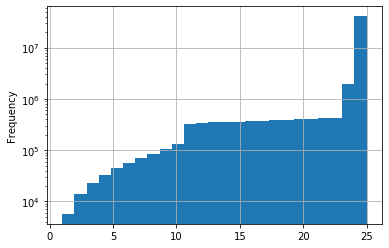

In [14]:
%%time
print('data size',items.shape,items['row_id'].unique().shape[0])
count = items['row_id'].value_counts()
items['row_id_count'] = items['row_id'].map(count)
count = items['item_id'].value_counts()
items['item_count'] = items['item_id'].map(count)

ax = items['row_id_count'].plot.hist(bins = len(candidates),grid=True,logy=True)
items = items[items['row_id_count']>1]
print('after removing leak, data size',items.shape,items['row_id'].unique().shape[0])

In [15]:
items.head()

,row_id,candidate_order,item_id,price,row_id_count,item_count
0,0,0,3400638,95,25,1155
1,0,1,1253714,66,25,224
2,0,2,3367857,501,25,399
3,0,3,5100540,112,25,533
4,0,4,1088584,95,25,350


In [16]:
%%time
items_gd = gd.from_pandas(items)

CPU times: user 4.04 s, sys: 1.86 s, total: 5.9 s
Wall time: 6.04 s


In [17]:
%%time
data['clickout_missing'] = data['clickout_missing'].astype(int)
data.drop_column('impressions')
data.drop_column('prices')

CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 82.4 ms


In [18]:
%%time
data_pair = items_gd.merge(data,on='row_id',how='left')

CPU times: user 1.1 s, sys: 1.06 s, total: 2.16 s
Wall time: 3.26 s


In [19]:
del items_gd
del data

In [20]:
%%time
data_pair['reference'] = data_pair['reference'].astype(int)
data_pair['item_id'] = data_pair['item_id'].astype(int)
data_pair['target'] = data_pair['reference'] == data_pair['item_id']
data_pair['target'] = data_pair['target'].astype(int)

CPU times: user 180 ms, sys: 76 ms, total: 256 ms
Wall time: 273 ms


In [21]:
data_pair.head().to_pandas()

,row_id,candidate_order,item_id,price,row_id_count,item_count,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,is_test,clickout_missing,target
0,1236,17,73376,399,25,113,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
1,1236,18,10348476,201,25,9,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
2,1236,19,407711,425,25,273,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
3,1236,20,9882224,153,25,12,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
4,1236,21,10455202,813,25,14,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0


In [22]:
data_pair = data_pair.to_pandas()

In [23]:
'0' in data_pair.item_id

False

In [24]:
data_pair.head()

,row_id,candidate_order,item_id,price,row_id_count,item_count,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,is_test,clickout_missing,target
0,1236,17,73376,399,25,113,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
1,1236,18,10348476,201,25,9,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
2,1236,19,407711,425,25,273,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
3,1236,20,9882224,153,25,12,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0
4,1236,21,10455202,813,25,14,XFE5BT9RNTQW,62f66f7671352,1541073311,6,clickout item,5993048,US,"Nashville, USA",desktop,Focus on Distance,0,0,0


In [ ]:
%%time
data_pair.to_pandas().to_pickle('cache/data_pair_clickout_only.pkl')